## Causality Analysis of Open Covid-19 Epidemiology Data in Madrid
By: Ke Li
Date: March28, 2021

### Process CSV Raw Data

In [103]:
%load_ext autoreload
%autoreload 2

import os, sys
project_root      = r"/home/coco/code/dlr/explore_tigramite"

path_to_data_src  = os.path.join(project_root, "src","data")
path_to_model_src = os.path.join(project_root, "src","model")

path_to_processed_data = os.path.join(project_root,"data","processed")
path_to_raw_data       = os.path.join(project_root,"data","raw")

sys.path.insert(0, path_to_data_src)
sys.path.insert(0, path_to_model_src)
sys.path.insert(0, path_to_processed_data)
sys.path.insert(0, path_to_raw_data)

import pandas as pd
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
epi = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/epidemiology.csv")

In [105]:
madrid = epi[epi.key == 'ES_MD']
madrid.tail()

,date,key,new_confirmed,new_deceased,new_recovered,new_tested,total_confirmed,total_deceased,total_recovered,total_tested
5630840,2021-03-21,ES_MD,361.0,9.0,NaN,NaN,612021.0,14516.0,NaN,NaN
5645963,2021-03-22,ES_MD,1524.0,13.0,NaN,NaN,613545.0,14529.0,NaN,NaN
5661208,2021-03-23,ES_MD,1851.0,1.0,NaN,NaN,615396.0,14530.0,NaN,NaN
5676551,2021-03-24,ES_MD,1449.0,0.0,NaN,NaN,616845.0,14530.0,NaN,NaN
5691526,2021-03-25,ES_MD,0.0,0.0,NaN,NaN,616845.0,14530.0,NaN,NaN


In [106]:
madrid_np = madrid.values # convert panda dataframe to numpy array

In [107]:
raw_data = np.empty((450,4))
raw_data[:,0] = madrid_np[:,2]
raw_data[:,1] = madrid_np[:,3]
raw_data[:,2] = madrid_np[:,6]
raw_data[:,3] = madrid_np[:,7]


In [120]:
from PrototypeWidgets import ProjectWindow
ProjectWindow().show()

In [56]:
import os
processed_data_folder = r"/home/coco/code/dlr/explore_tigramite/data/processed"
np.savez(os.path.join(processed_data_folder, "kl-01-open_coviddata_epidemiology_madrid.npz"), raw_data) #save data to processed folder


### Causality Analysis with Tigramite

In [108]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline    

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

In [109]:
# Initialize dataframe object, specify time axis and variable names
#var_names = ["new_confirmed", "new_deceased","total_confirmed","total_deceased"]
var_names = ["c", "d",r'$T_c$',r'$T_d$']
dataframe = pp.DataFrame(raw_data, 
                         datatime = np.arange(len(raw_data)), 
                         var_names=var_names)

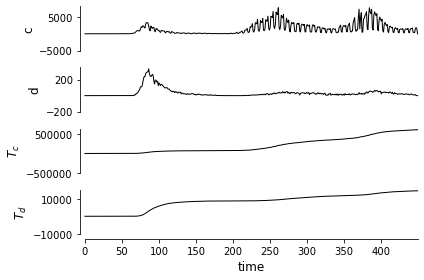

In [99]:
tp.plot_timeseries(dataframe); plt.show()

In [112]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


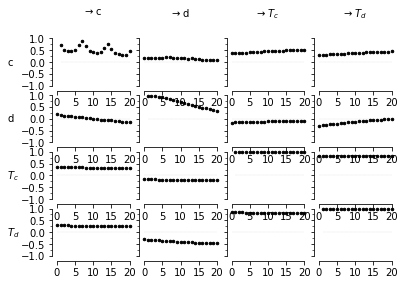

In [114]:
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

In [115]:
pcmci.verbosity = 1
results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable c has 3 parent(s):
    [pc_alpha = 0.5]
        (c -2): max_pval = 0.24606, min_val = -0.055
        (d -1): max_pval = 0.35809, min_val =  0.044
        (d -2): max_pval = 0.45419, min_val =  0.036

    Variable d has 3 parent(s):
    [pc_alpha = 0.4]
        (d -2): max_pval = 0.05583, min_val =  0.091
        ($T_c$ -2): max_pval = 0.39858, min_val = -0.040
        ($T_c$ -1): max_pval = 0.39992, min_val = -0.040

    Variable $T_c$ has 4 parent(s):
    [pc_alpha = 0.1]
        ($T_c$ -1): max_pval = 0.00000, min_val =  0.868
        ($T_c$ -2): max_pval = 0.00000, min_val = -0.598
        (c -2): max_pval = 0.06750, min_val = -0.087
        (d -1): max_pval = 0.09822, min_val =  0.079

    Variable $T_d$ has 3 parent(s):
  

In [116]:
print("p-values")
print (results['p_matrix'].round(3))
print("MCI partial correlations")
print (results['val_matrix'].round(2))

p-values
[[[1.    0.    0.   ]
  [0.    0.713 0.007]
  [0.    0.821 0.001]
  [0.    0.597 0.799]]

 [[0.    0.    0.026]
  [1.    0.    0.   ]
  [0.    0.901 0.76 ]
  [0.    0.959 0.027]]

 [[0.    0.    0.942]
  [0.    0.    0.   ]
  [1.    0.    0.964]
  [0.    0.288 0.45 ]]

 [[0.    0.96  0.606]
  [0.    0.    0.941]
  [0.    0.969 0.309]
  [1.    0.    0.649]]]
MCI partial correlations
[[[ 0.    0.63  0.35]
  [ 0.25 -0.02 -0.13]
  [ 1.   -0.01 -0.15]
  [ 0.24  0.03 -0.01]]

 [[ 0.25  0.19 -0.11]
  [ 0.    0.65  0.69]
  [ 0.25  0.01  0.01]
  [ 1.    0.    0.11]]

 [[ 1.    0.61  0.  ]
  [ 0.25  0.2  -0.17]
  [ 0.    0.87  0.  ]
  [ 0.26  0.05 -0.04]]

 [[ 0.24 -0.   -0.02]
  [ 1.    0.64 -0.  ]
  [ 0.26  0.   -0.05]
  [ 0.    0.88  0.02]]]


In [117]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable c has 7 link(s):
        ($T_c$  0): pval = 0.00000 | qval = 0.00000 | val =  1.000
        (c -1): pval = 0.00000 | qval = 0.00000 | val =  0.630
        ($T_c$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.612
        (c -2): pval = 0.00000 | qval = 0.00000 | val =  0.348
        (d  0): pval = 0.00000 | qval = 0.00000 | val =  0.252
        ($T_d$  0): pval = 0.00000 | qval = 0.00000 | val =  0.241
        (d -1): pval = 0.00008 | qval = 0.00025 | val =  0.187

    Variable d has 8 link(s):
        ($T_d$  0): pval = 0.00000 | qval = 0.00000 | val =  1.000
        (d -2): pval = 0.00000 | qval = 0.00000 | val =  0.685
        (d -1): pval = 0.00000 | qval = 0.00000 | val =  0.648
        ($T_d$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.644
        ($T_c$  0): pval = 0.00000 | qval = 0.00000 | val =  0.252
        (c  0): pval = 0.00000 | qval = 0.00000 | val =  0.252
        ($T_c$ -1): pval = 0.00004 | qval = 0.00013 | va

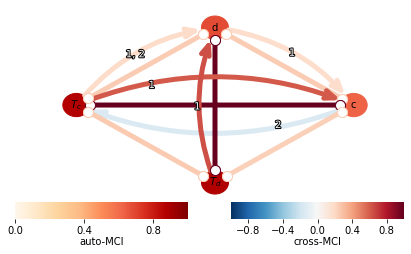

In [118]:
link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

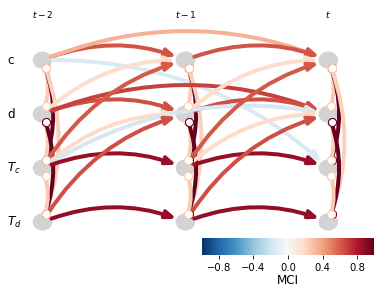

In [119]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

### 